In [227]:
import h5py as h5
import arepo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d
from numba import njit
import importlib
import galaxy
from scipy.spatial import KDTree
from scipy.stats import gaussian_kde

basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

In [19]:
def load_log(fname):
    log = np.genfromtxt(fname)
    _, indices = np.unique(log[:,0], return_index=True)
    log = log[sorted(indices)]
    return log

In [20]:
sfr = {}
Rs_list = ['116', '129', '142']
Vv_list = ['116', '129', '142']
ecc_list = ['04', '05', '06']
for Rs in Rs_list:
    sfr[Rs] = {}
    for Vv in Vv_list:
        sfr[Rs][Vv] = {}
        for ecc in ecc_list:
            key = 'lvl4-Rs'+Rs+'-Vv'+Vv+'-e'+ecc
            sfr[Rs][Vv][ecc] = load_log(basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/' + key + '/output/sfr.txt')

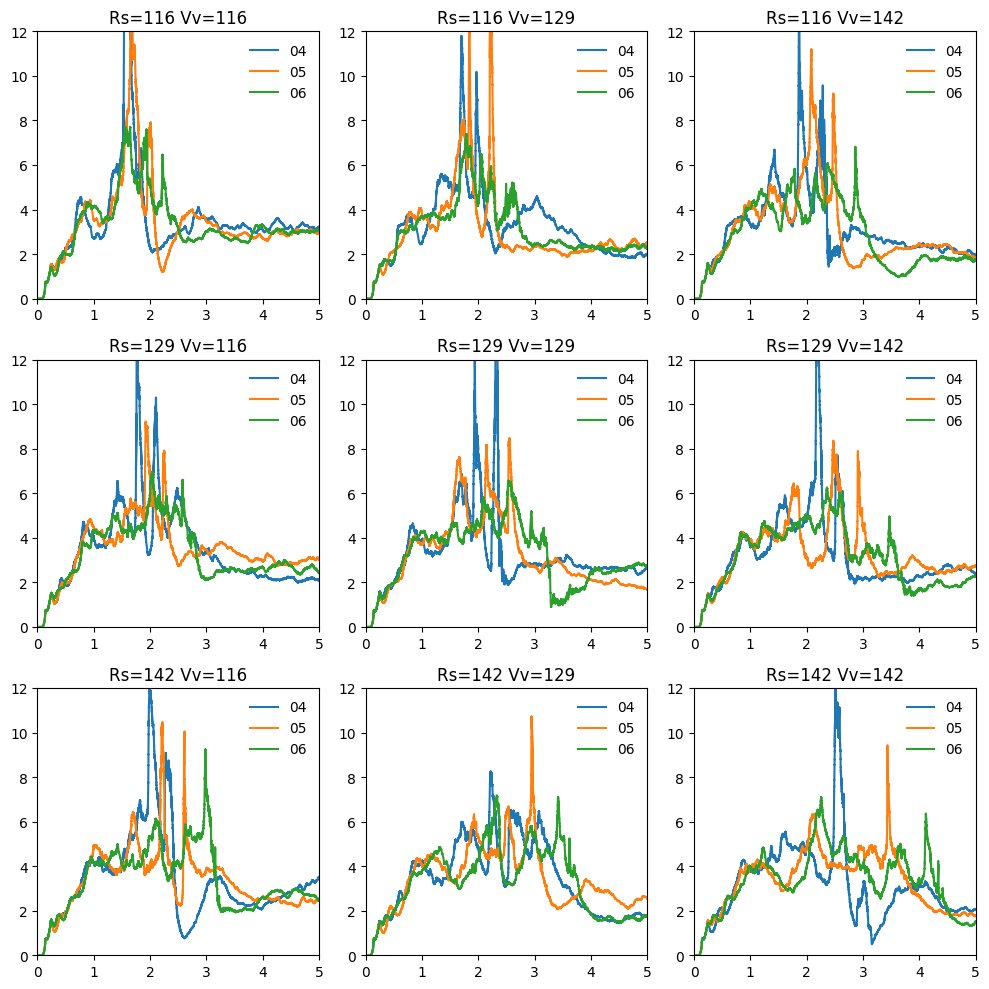

In [21]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for i,Rs in enumerate(Rs_list):
    for j,Vv in enumerate(Vv_list):
        ax = axs[i][j]
        for ecc in ecc_list:
            ax.plot(sfr[Rs][Vv][ecc][:,0], sfr[Rs][Vv][ecc][:,2], label=ecc)
        
        ax.set(xlim=(0, 5), ylim=(0, 12), title='Rs='+Rs+' Vv='+Vv)
        ax.legend(frameon=False)

fig.tight_layout()

In [226]:
idx = 320

gals = {}
Rs_list = ['116', '129', '142']
Vv_list = ['116', '129', '142']
ecc_list = ['04', '05', '06']
for Rs in Rs_list:
    gals[Rs] = {}
    for Vv in tqdm(Vv_list):
        gals[Rs][Vv] = {}
        for ecc in ecc_list:
            key = 'lvl4-Rs'+Rs+'-Vv'+Vv+'-e'+ecc
            gals[Rs][Vv][ecc] = galaxy.Galaxy(basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/' + key + '/output',
                                              idx, orient=True)
gals['iso'] = galaxy.Galaxy(basepath + 'runs/MW7iso/lvl4-Ngb64/output', idx, orient=True)

100%|██████████| 3/3 [00:27<00:00,  9.19s/it]


In [73]:
def get_logFeH_logMgFe(gal, ptype=4):
    GFM_SOLAR_ABUNDANCE_HYDROGEN = 0.7388
    GFM_SOLAR_ABUNDANCE_MAGNESIUM = 0.0007
    GFM_SOLAR_ABUNDANCE_IRON   =   0.0013
    
    part = getattr(gal.sn, 'part'+str(ptype))
    
    FeH = part.GFM_Metals[:,8] / GFM_SOLAR_ABUNDANCE_IRON
    logFeH = np.log10(FeH)

    MgH = part.GFM_Metals[:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
    MgFe = MgH/FeH
    logMgH = np.log10(MgH)
    logMgFe = np.log10(MgFe)
    
    return logFeH, logMgH, logMgFe


def in_SN(gal, ptype, Rmin=4, Rmax=16, zmin=0, zmax=3, dLz=0.1):
    part = getattr(gal.sn, 'part'+str(ptype))
    # R = np.linalg.norm(part.rotpos[:,:2], axis=1)
    # z = part.rotpos[:,2]
    # key_R = np.logical_and(R < Rmax, R > Rmin)
    # key = np.logical_and(key_R, np.abs(z) < zmax)
    # key = np.logical_and(key, np.abs(z) > zmin)
    
    pos = part.rotpos
    vel = part.rotvel
    Lz = np.cross(pos, vel)[:,2]
    
    Lzsun = 8*220
    key = np.logical_and((Lz/Lzsun)-1 < dLz, np.abs(pos[:,2]) < zmax)
    
    return key

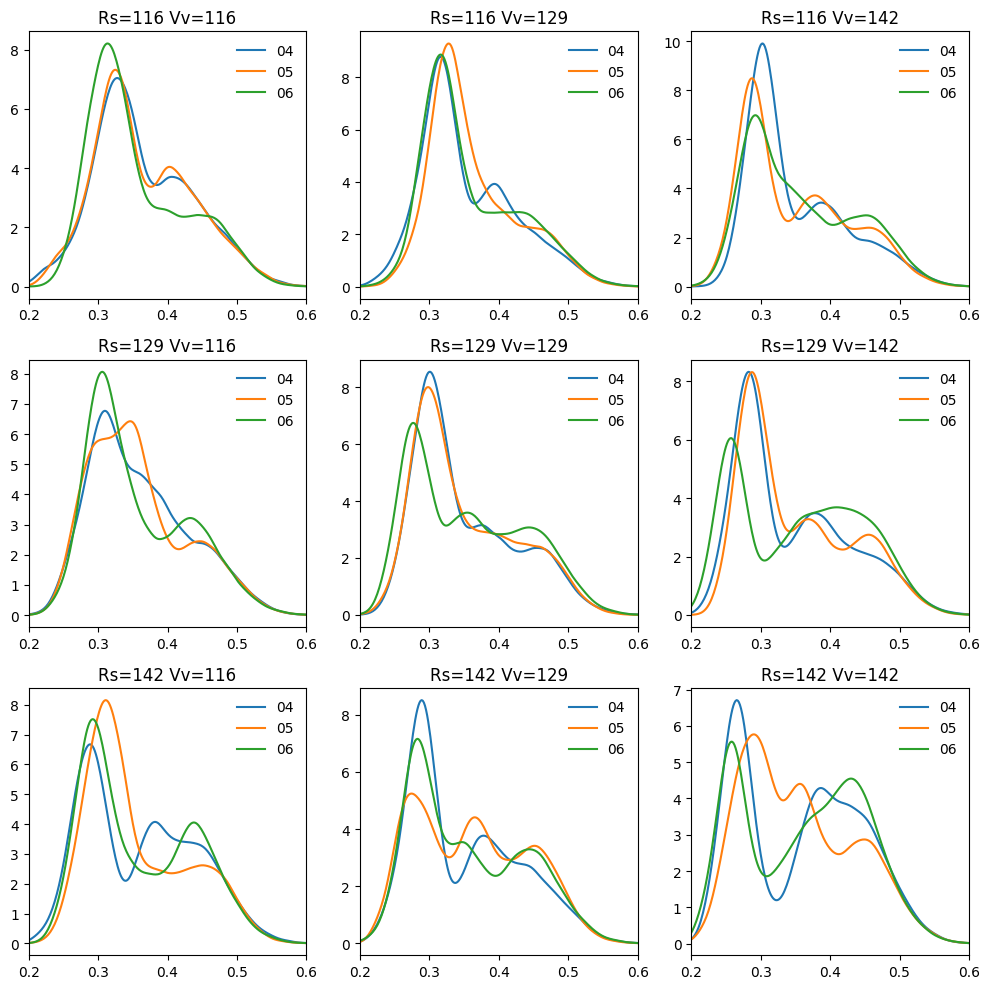

In [82]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

Rmin = 5
Rmax = 10
zmin = 0
zmax = 3

logMgFe_bins = np.linspace(0.2, 0.6, 256+1)

logFeH_min = -0.75
logFeH_max = -0.25


for i,Rs in enumerate(Rs_list):
    for j,Vv in enumerate(Vv_list):
        ax = axs[i][j]
        for ecc in ecc_list:
            # if is_bimodal[Rs][Vv][ecc] > 0:
                # continue
                
            gal = gals[Rs][Vv][ecc]

            logFeH, logMgH, logMgFe = get_logFeH_logMgFe(gal)
            is_in_SN = in_SN(gal, 4, Rmin=Rmin, Rmax=Rmax, zmin=zmin, zmax=zmax)
        
            
            key = np.logical_and(logFeH > logFeH_min, logFeH < logFeH_max)
            key = np.logical_and(key, is_in_SN)
            
            kernel = gaussian_kde(logMgFe[key], weights=gal.sn.part4.mass.value[key])
            val = kernel(logMgFe_bins)
            
            ax.plot(logMgFe_bins, val, label=ecc)
            
        ax.set(xlim=(logMgFe_bins[0], logMgFe_bins[-1]), title='Rs='+Rs+' Vv='+Vv)
        ax.legend(frameon=False)

fig.tight_layout()

In [83]:
is_bimodal = {}
Rs_list = ['116', '129', '142']
Vv_list = ['116', '129', '142']
ecc_list = ['04', '05', '06']
for Rs in Rs_list:
    is_bimodal[Rs] = {}
    for Vv in Vv_list:
        is_bimodal[Rs][Vv] = {}
        for ecc in ecc_list:
            is_bimodal[Rs][Vv][ecc] = 2

# is unimodal
is_bimodal['116']['129']['05'] = 0
is_bimodal['129']['116']['04'] = 0
is_bimodal['129']['129']['05'] = 0

            
# is bimodal
# is_bimodal['116']['129']['04'] = 1
# is_bimodal['116']['142']['04'] = 1
# is_bimodal['116']['142']['05'] = 1
# is_bimodal['129']['116']['06'] = 1
# is_bimodal['129']['142']['06'] = 1
# is_bimodal['142']['116']['04'] = 1
is_bimodal['142']['116']['06'] = 1
# is_bimodal['142']['129']['04'] = 1
is_bimodal['142']['142']['04'] = 1
is_bimodal['142']['142']['06'] = 1

# is marginal or multimodal
# is_bimodal['116']['142']['03'] = 2
# is_bimodal['129']['116']['05'] = 2
# is_bimodal['116']['116']['05'] = 2
# is_bimodal['129']['142']['05'] = 2
# is_bimodal['142']['129']['05'] = 2
# is_bimodal['142']['129']['06'] = 2
# is_bimodal['142']['142']['05'] = 2


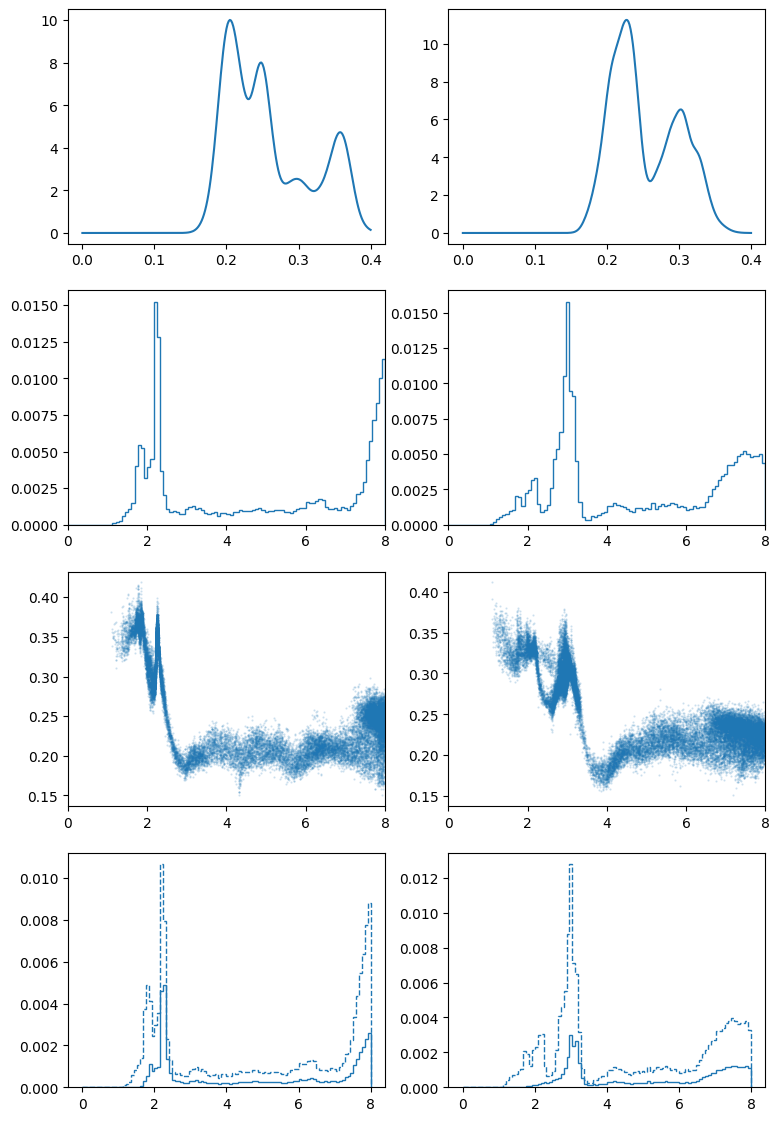

In [133]:
fig, ax = plt.subplots(4, 2, figsize=(9, 14))

logMgFe_bins = np.linspace(0, 0.4, 256+1)

logFeH_min = 0.15
logFeH_max = 0.25
alpha = [0.9, 0.9]
dalpha = 0.2

tformbins = np.linspace(0, 8, 100+1)

num_plotted = [0, 0]

for Rs in Rs_list:
    for Vv in Vv_list:
        for ecc in ecc_list:
            if is_bimodal[Rs][Vv][ecc] == 0:
                pidx = 0
            elif is_bimodal[Rs][Vv][ecc] == 1:
                pidx = 1
            else:
                continue
            
            if num_plotted[pidx] > 0:
                continue
            
            gal = gals[Rs][Vv][ecc]

            logFeH, logMgH, logMgFe = get_logFeH_logMgFe(gal)
            is_in_SN = in_SN(gal, 4)
            
            key = np.logical_and(logFeH > logFeH_min, logFeH < logFeH_max)
            key = np.logical_and(key, is_in_SN)
            
            totmass = np.sum(gal.sn.part4.mass.value[key])
            weights = gal.sn.part4.mass[key].value/totmass
            
            kernel = gaussian_kde(logMgFe[key], weights=weights)
            val = kernel(logMgFe_bins)
            
            l = ax[0][pidx].plot(logMgFe_bins, val)
            
            # SFH at this metallicity
            tform = gal.sn.part4.GFM_StellarFormationTime
            
            # kernel = gaussian_kde(tform[key], weights=weights)
            # tlist = np.linspace(0, 8, 1000)
            # ax[1][pidx].plot(tlist, kernel(tlist), c=l[0].get_color())
            
            birthmass = gal.sn.part4.GFM_InitialMass
            
            ax[1][pidx].hist(tform[key], bins=tformbins, color=l[0].get_color(), 
                             weights=birthmass[key], histtype='step')
            
            birthGSEmass = gal.sn.part4.PassiveScalars[:,2] * birthmass
            ax[3][pidx].hist(tform[key], bins=tformbins, color=l[0].get_color(),
                             weights=birthGSEmass[key], histtype='step')
            
            birthMWmass = gal.sn.part4.PassiveScalars[:,0] * birthmass
            ax[3][pidx].hist(tform[key], bins=tformbins, color=l[0].get_color(),
                             weights=birthMWmass[key], histtype='step', ls='dashed')
            
            if num_plotted[pidx] == 0:
                ax[2][pidx].scatter(tform[key], logMgFe[key], s=0.3, alpha=0.2)
            
            num_plotted[pidx] += 1
            
            ax[1][pidx].set(xlim=(0, 8))
            ax[2][pidx].set(xlim=(0, 8))
            
            # alpha[pidx] -= dalpha


In [94]:
def get_logFeH_logMgFe(gal, ptype=4):
    GFM_SOLAR_ABUNDANCE_HYDROGEN = 0.7388
    GFM_SOLAR_ABUNDANCE_MAGNESIUM = 0.0007
    GFM_SOLAR_ABUNDANCE_IRON   =   0.0013
    
    part = getattr(gal.sn, 'part'+str(ptype))
    
    FeH = part.GFM_Metals[:,8] / GFM_SOLAR_ABUNDANCE_IRON
    logFeH = np.log10(FeH)

    MgH = part.GFM_Metals[:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
    MgFe = MgH/FeH
    logMgH = np.log10(MgH)
    logMgFe = np.log10(MgFe)
    
    return logFeH, logMgH, logMgFe
    
def plot_map(fig, ax, gal, scalar=None, subsamp=None, tform_min=0, tform_max=10,
             Rmin=4, Rmax=16, zmin=0, zmax=3, exclude=None, nres=50, sigma=1,
             logFeH_min=-1.1, logFeH_max=0.2, logMgFe_min=0.15, logMgFe_max=0.65,
             K=64, vmin=None, vmax=None, asymmetry=False, norm=0, cmap=None):
    
    # vmin = None
    # vmax = 0.008
    # vmax = None
    
    logFeH, logMgH, logMgFe = get_logFeH_logMgFe(gal)
    
    key = in_SN(gal, 4, Rmin=Rmin, Rmax=Rmax, zmin=zmin, zmax=zmax)
    
    tform = gal.sn.part4.GFM_StellarFormationTime
    key = np.logical_and(key, tform > tform_min)
    key = np.logical_and(key, tform < tform_max)
    
    if exclude is not None:
        key_low = np.logical_and(key, tform < exclude[0])
        key_high = np.logical_and(key, tform > exclude[1])
        key = np.logical_or(key_low, key_high)
    
    data = np.vstack((logFeH[key], logMgFe[key])).T
    N = len(data)
    tree = KDTree(data)
        
    dlogFeH = (logFeH_max - logFeH_min)/nres
    dlogMgFe = (logMgFe_max - logMgFe_min)/nres
        
    logFeH_lin = np.linspace(logFeH_min + dlogFeH, logFeH_max-dlogFeH, nres)
    logMgFe_lin = np.linspace(logMgFe_min + dlogMgFe, logMgFe_max-dlogMgFe, nres)
    
    logFeH_grid, logMgFe_grid = np.meshgrid(logFeH_lin, logMgFe_lin)
    grid = np.vstack([logFeH_grid.ravel(), logMgFe_grid.ravel()]).T

    distances, indices = tree.query(grid, k=K)
    kth_distances = distances[:, -1]
    
    tmp = np.reshape(kth_distances, (nres, nres))
    
    # Calculate the density: Inverse of the area of the circle surrounding the Kth neighbor
    density = K / (N * np.pi * kth_distances**2)
    density = np.reshape(density, logFeH_grid.shape).T
    
    downstairs = np.max(density, axis=1)
    
    # downstairs = np.sum(mbin, axis=1)
    # vmin = 0.01
    # vmax = 0.2
    
    if norm == 0:
        # norm = None
        norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
        # norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        # norm = mpl.colors.PowerNorm(gamma=0.5)
    
    downstairs[downstairs == 0.0] = 1e-20
    density = (density.T / downstairs).T
    density[density < norm.vmin] = norm.vmin
        
    extent = [logFeH_min, logFeH_max, logMgFe_min, logMgFe_max]
    
    
    
    # density = density**alpha
    # density[density > 1] = density[density > 1]**0.3
    if asymmetry:
        # grad_logFeH, grad_logMgFe = np.gradient(density)
        # grad_mag = np.sqrt(grad_logFeH**2 + grad_logMgFe**2)
        # density = grad_mag/density
        # density = grad_logMgFe
        # print(grad_mag.shape)
        
        neighbors = data[indices]
        print(neighbors.shape)
        com = np.mean(neighbors, axis=1)
        print(com.shape)
        d = distances[:,-1]
        asymmetry_values = (com[:, 1] - grid[:, 1]) / d
        
        tenperc = np.percentile(density, 10)
        tenperc = density < tenperc
        
        asymmetry_grid = asymmetry_values.reshape((nres, nres)).T
        density = asymmetry_grid
        # density[tenperc] = 0.0
        
    
    # percentiles = np.zeros_like(density)
    # for i in range(density.shape[1]):
        # column = density[i,:]
        # density[i,:] = rankdata(density[i,:], method='max') / len(column)
    
    im = ax.imshow(density.T, origin='lower',
               extent=extent,
               norm=norm, cmap=cmap)

    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    ax.set_aspect('auto')
    
    return im

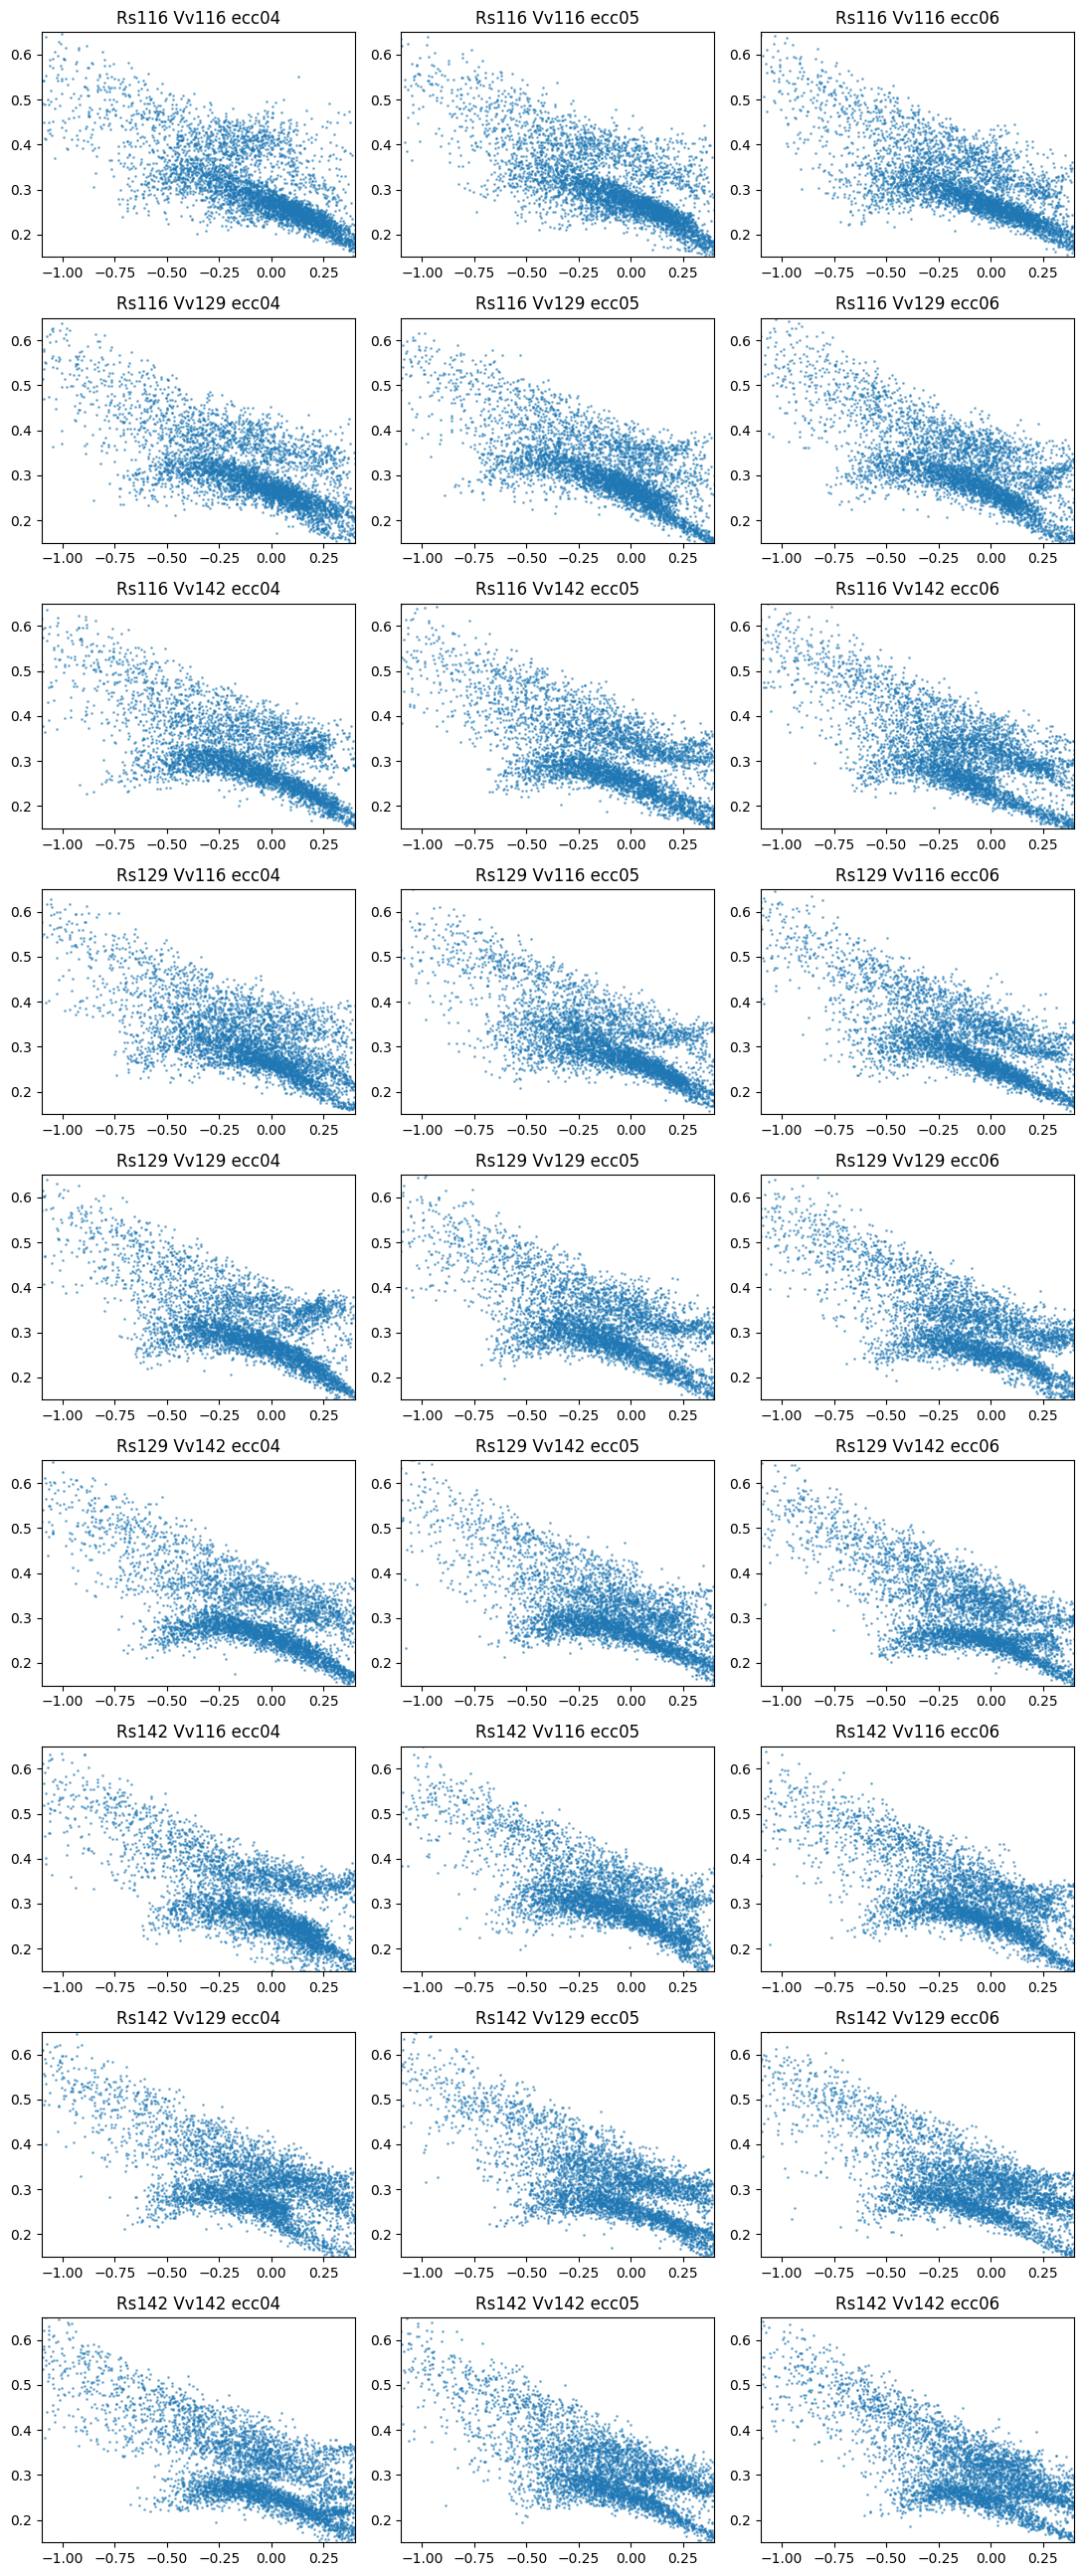

In [125]:
fig, axs = plt.subplots(9, 3, figsize=(11, 26))

ax_col = [0, 0]

logFeH_min=-1.1
logFeH_max=0.4
logMgFe_min=0.15
logMgFe_max=0.65

subsamp = 5000

i = 0
for Rs in Rs_list:
    for Vv in Vv_list:
        for ecc in ecc_list:
            # if is_bimodal[Rs][Vv][ecc] == 0:
                # pidx = 0
            # elif is_bimodal[Rs][Vv][ecc] == 1:
                # pidx = 1
            # else:
                # continue
            
            # ax = axs[pidx][ax_col[pidx]]
            ax = axs.ravel()[i]
            gal = gals[Rs][Vv][ecc]
            
            # norm = mpl.colors.Normalize(0, 1)
            # plot_map(fig, ax, gal, norm=norm)
            
            logFeH, logMgH, logMgFe = get_logFeH_logMgFe(gal)
            is_in_SN = in_SN(gal, 4)
            
            key = np.where(is_in_SN)[0]
            key = np.random.choice(key, subsamp, replace=False)
            
            # print(logFeH[:10])
            # logFeH = np.random.normal(logFeH, 0.02)
            # print(logFeH[:10])
            # logMgFe = np.random.normal(logMgFe, 0.04)
            
            ax.scatter(logFeH[key], logMgFe[key], s=1, alpha=0.5)
            ax.set(xlim=(logFeH_min, logFeH_max), ylim=(logMgFe_min, logMgFe_max))
            
            ax.set_title('Rs'+Rs+' Vv'+Vv+' ecc'+ecc)
            # ax_col[pidx] += 1
            i += 1

fig.tight_layout()

In [120]:
idx = 320
galiso = galaxy.Galaxy(basepath + 'runs/MW7iso/lvl4-Ngb64/output', idx, orient=True)

[Text(0.5, 0, '[Fe/H]'), Text(0, 0.5, '[Mg/Fe]')]

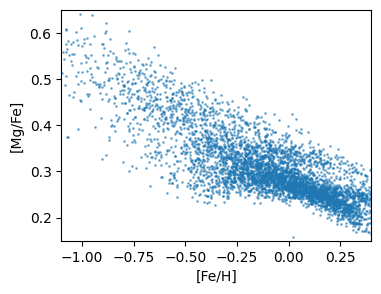

In [189]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

gal = galiso

logFeH_min=-1.1
logFeH_max=0.4
logMgFe_min=0.15
logMgFe_max=0.65

subsamp = 5000

logFeH, logMgH, logMgFe = get_logFeH_logMgFe(gal)
is_in_SN = in_SN(gal, 4)
            
key = np.where(is_in_SN)[0]
key = np.random.choice(key, subsamp, replace=False)
            
ax.scatter(logFeH[key], logMgFe[key], s=1, alpha=0.5)
ax.set(xlim=(logFeH_min, logFeH_max), ylim=(logMgFe_min, logMgFe_max))
ax.set(xlabel='[Fe/H]', ylabel='[Mg/Fe]')

In [251]:
def make_plot(Rs, Vv, ecc, iso=False, exclude=None, save=True):
    logFeH_min=-1.1
    logFeH_max=0.6
    logMgFe_min=0.1
    logMgFe_max=0.65

    dlogFeH = 0.1

    fig, axs = plt.subplots(4, 1, figsize=(4, 12))

    if iso:
        gal = gals['iso']
    else:
        gal = gals[Rs][Vv][ecc]

    logFeH, logMgH, logMgFe = get_logFeH_logMgFe(gal)
    is_in_SN = in_SN(gal, 4)
    
    tform = gal.sn.part4.GFM_StellarFormationTime
    if exclude is not None:
        exclude_bool = np.logical_or(tform < exclude[0], tform > exclude[1])
        is_in_SN = np.logical_and(is_in_SN, exclude_bool)
            
    subsamp = 5000
    key = np.where(is_in_SN)[0]
    key = np.random.choice(key, subsamp, replace=False)
                        
    axs[0].scatter(logFeH[key], logMgFe[key], s=1, alpha=0.5, c='k')
    axs[0].set(xlim=(logFeH_min, logFeH_max), ylim=(logMgFe_min, logMgFe_max))
    
    if iso:
        if exclude is None:
            axs[0].set_title('isolated')
        else:
            axs[0].set_title('isolated exclude '+str(exclude[0])+' to '+str(exclude[1]))
    else:
        axs[0].set_title('Rs'+Rs+' Vv'+Vv+' ecc'+ecc)
    axs[0].set(xlabel='[Fe/H]', ylabel='[Mg/Fe]')

    # for logFeH0 in [-0.75, -0.5, -0.25, 0, 0.25]:
    offset = -0.3
    for i,logFeH0 in enumerate([-0.5, -0.25, 0, 0.25]):
        key = np.logical_and(logFeH > logFeH0 - dlogFeH/2., logFeH < logFeH0 + dlogFeH/2.)
        key = np.logical_and(key, is_in_SN)
    
        kernel = gaussian_kde(logMgFe[key])
        xlist = np.linspace(-3, 3, 1000+1)
        val = kernel(xlist)
            
        # l = axs[1].plot(xlist+offset, val)
        _, _, l = axs[1].hist(logMgFe[key]+offset, bins=np.linspace(logMgFe_min-0.2, logMgFe_max+0.4, 100+1))
        # print(l)
        c = l[0].get_facecolor()
        axs[0].axvline(logFeH0, c=c)
    
        offset += 0.3
    
        # SFH
        
        # kernel = gaussian_kde(tform[key], bw_method='silverman')
        # xlist = np.linspace(0, 8, 1000+1)
        # val = kernel(xlist)
    
        # axs[2].plot(xlist, val, c=c)
        # if i==0 or i==3:
        if False:
            alpha=0.8
            lw = 1
        else:
            alpha=1
            lw = 1.45
        h = axs[2].hist(tform[key], bins=np.linspace(0, 8, 64+1), histtype='step', alpha=alpha, lw=lw)
    
        # alpha vs tform
        key = np.where(key)[0]
        # key = np.random.choice(key, int(0.1*len(key) + 0.5), replace=False)
        key = np.random.choice(key, 3000, replace=False)
        axs[3].scatter(tform[key], logMgFe[key]+offset, alpha=0.3, color=c, s=0.1)

    axs[1].set(xlim=(logMgFe_min-0.2, logMgFe_max+0.4), ylim=(0, 8000))
    axs[2].set(xlim=(0, 8), ylim=(0, None))

    axs[1].set(xlabel='[Mg/Fe] + offset', ylabel='count')
    axs[2].set(xlabel='formation time [Gyr]', ylabel='count')
    axs[3].set(xlabel='formation time [Gyr]', ylabel='[Mg/Fe] + offset')
    
    fig.tight_layout()
    
    if save:
        if iso:
            if exclude is None:
                fig.savefig('fig/isolated.png')
            else:
                fig.savefig('fig/isolated_exclude'+str(exclude[0])+'_'+str(exclude[1])+'.png')
        else:
            fig.savefig('fig/Rs'+Rs+'_Vv'+Vv+'_e'+ecc+'.png')
    
        plt.close()

In [230]:
print(0)

0


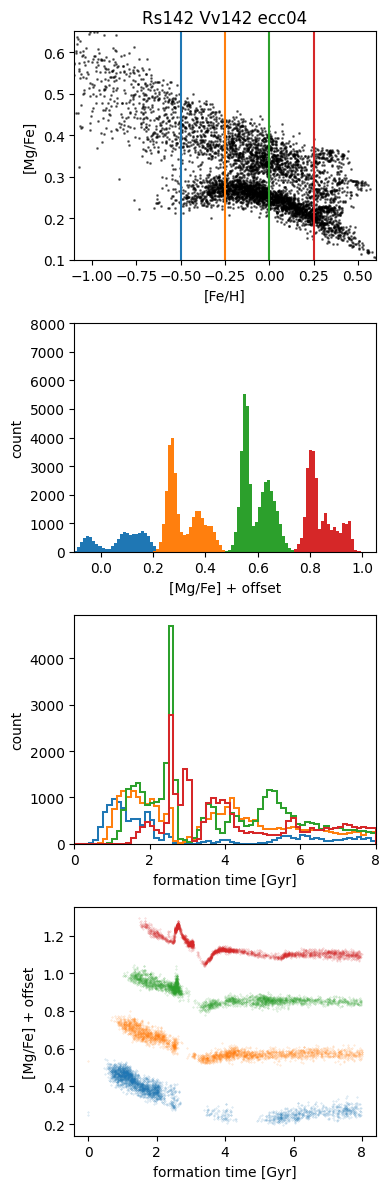

In [252]:
make_plot('142', '142', '04', save=False)

In [253]:
make_plot(None, None, None, iso=True)
make_plot(None, None, None, iso=True, exclude=(2.5, 3.5))

In [254]:
for Rs in Rs_list:
    for Vv in tqdm(Vv_list):
        for ecc in ecc_list:
            make_plot(Rs, Vv, ecc)

100%|██████████| 3/3 [00:20<00:00,  6.76s/it]


In [106]:
idx = 320
gals_idx = {}
gals_idx['MW7_GSE4_Rs142_Vv142_e04_l5'] = \
    galaxy.Galaxy(basepath + 'runs/MW7_GSE4-eRVgrid-lvl5/lvl5-Rs142-Vv142-e04/output', idx, orient=True)

gals_idx['MW7_GSE4_Rs142_Vv142_e04_l4'] = \
    galaxy.Galaxy(basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/lvl4-Rs142-Vv142-e04/output', idx, orient=True)

# gals_idx['MW7_GSE4_Rs142_Vv142_e04_l3'] = \
    # galaxy.Galaxy(basepath + 'runs/MW7_GSE4-eRVgrid-lvl3/lvl3-Rs142-Vv142-e04/output', idx, orient=True)

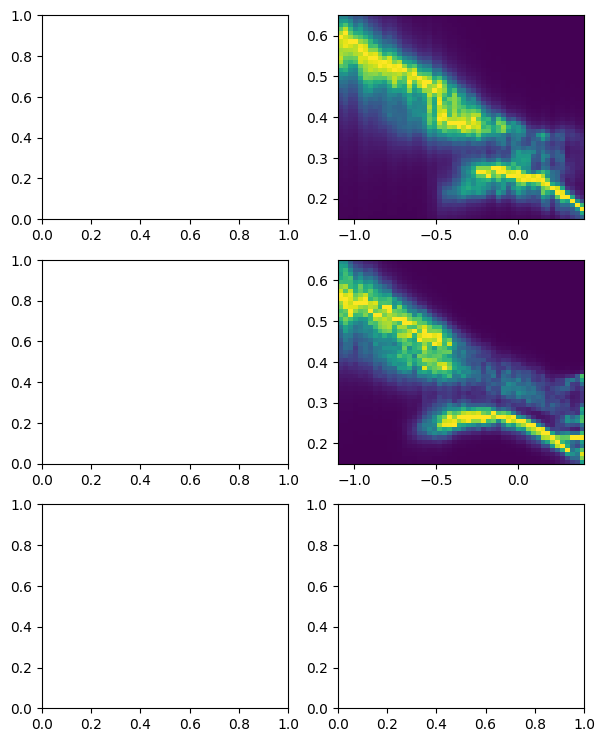

In [107]:
fig, axs = plt.subplots(3, 2, figsize=(7, 9))

# Rmin = 5
# Rmax = 11
# zmax = 3
Rmin = 6
Rmax = 11
zmin = 0
zmax = 3

norm = mpl.colors.Normalize(0, 1)
plot_map(fig, axs[0][1], gals_idx['MW7_GSE4_Rs142_Vv142_e04_l5'], norm=norm)
plot_map(fig, axs[1][1], gals_idx['MW7_GSE4_Rs142_Vv142_e04_l4'], norm=norm)
# plot_map(fig, axs[2][1], gals_idx['MW7_GSE4_Rs142_Vv142_e04_l3'], norm=norm)

logFeH0= -0.5 min= -0.75  max= -0.25
logFeH0= -0.4 min= -0.65  max= -0.15000000000000002
logFeH0= -0.35 min= -0.6  max= -0.09999999999999998
logFeH0= -0.3 min= -0.55  max= -0.04999999999999999
logFeH0= -0.2 min= -0.45  max= 0.04999999999999999


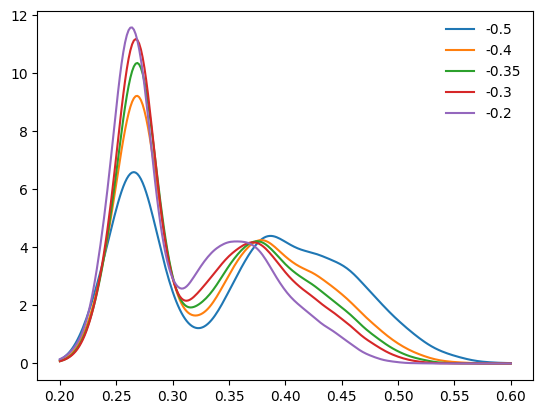

In [70]:
gal = gals['MW7_GSE4_Rs142_Vv142_e04_l4']

dlogFeH = 0.5
logMgFe_bins = np.linspace(0.2, 0.6, 256+1)
for logFeH0 in [-0.5, -0.4, -0.35, -0.3, -0.2]:
    logFeH, logMgH, logMgFe = get_logFeH_logMgFe(gal)
    key = np.logical_and(logFeH > logFeH0 - dlogFeH/2, logFeH < logFeH0 + dlogFeH/2)
    print('logFeH0=', logFeH0, 'min=', logFeH0-dlogFeH/2, ' max=', logFeH0+dlogFeH/2)
    
    kernel = gaussian_kde(logMgFe[key], weights=gal.sn.part4.mass.value[key])
    val = kernel(logMgFe_bins)
            
    plt.plot(logMgFe_bins, val, label=str(logFeH0))
    
plt.legend(frameon=False)